<a href="https://colab.research.google.com/github/Aleksypruszkowski/Machine-Learning-MIMUW/blob/main/Lab12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 12 - Natural Language Processing - Towards Attention


### Author: Aleksy Pruszkowski

Let's use GloVe pretrained embeddings from Stanford University.

In [2]:
!wget https://nlp.stanford.edu/data/wordvecs/glove.42B.300d.zip
import zipfile
with zipfile.ZipFile("glove.42B.300d.zip", 'r') as zip_ref:
    zip_ref.extractall()

--2025-06-04 21:09:13--  https://nlp.stanford.edu/data/wordvecs/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.42B.300d.zip [following]
--2025-06-04 21:09:14--  https://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877802108 (1.7G) [application/zip]
Saving to: ‘glove.42B.300d.zip’

glove.42B.300d.zip  100%[===================>]   1.75G  5.01MB/s    in 5m 53s  

2025-06-04 21:15:07 (5.07 MB/s) - ‘glove.42B.300d.zip’ saved [1877802108/1877802108]



In [3]:
import numpy as np

glove_vectors = {}

with open('glove.42B.300d.txt', "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split()
        word = parts[0]
        try:
            vector = np.array([float(x) for x in parts[1:]])
            glove_vectors[word] = vector
        except ValueError:
            continue

# (len(glove_vectors), next(iter(glove_vectors.values())).shape)


(1917495, (300,))

In [4]:
semantic_classes = {
    "Gender": [("king", "queen"), ("man", "woman"), ("actor", "actress"), ("prince", "princess"), ("father", "mother")],
    "Past tense": [("bring", "brought"), ("get", "got"), ("like", "liked"), ("write", "wrote"), ("speak", "spoke")],
    "Singular/plural": [("cat", "cats"), ("dog", "dogs"), ("flower", "flowers"), ("tree", "trees"), ("table", "tables")],
    "Country/Capital": [("france", "paris"), ("germany", "berlin"), ("russia", "moscow"), ("italy", "rome"), ("japan", "tokyo")],
    "Comparative": [("big", "bigger"), ("small", "smaller"), ("fast", "faster"), ("slow", "slower"), ("tall", "taller")],
    "Superlative": [("big", "biggest"), ("small", "smallest"), ("fast", "fastest"), ("slow", "slowest"), ("tall", "tallest")],
    "Tool/object": [("saw", "wood"), ("pen", "paper"), ("brush", "paint"), ("scissors", "paper"), ("shovel", "dirt")],
    "Job/workplace": [("teacher", "school"), ("chef", "restaurant"), ("doctor", "hospital"), ("farmer", "farm"), ("librarian", "library")],
    "City/US zip code": [("honolulu", "96817"), ("pittsburg", "94565"), ("brooklyn", "11234"), ("westminster", "92683"), ("anaheim", "92804")],
    "Currency": [("usa", "dollar"), ("uk", "pound"), ("japan", "yen"), ("europe", "euro"), ("india", "rupee")]
}

filtered_classes = {}
for class_name, pairs in semantic_classes.items():
    valid_pairs = [(a, b) for (a, b) in pairs if a in glove_vectors and b in glove_vectors]
    # print(valid_pairs)
    if valid_pairs:
        filtered_classes[class_name] = valid_pairs
total_pairs = sum(len(pairs) for pairs in filtered_classes.values())
valid_class_count = len(filtered_classes)

# valid_class_count, total_pairs

(10, 50)

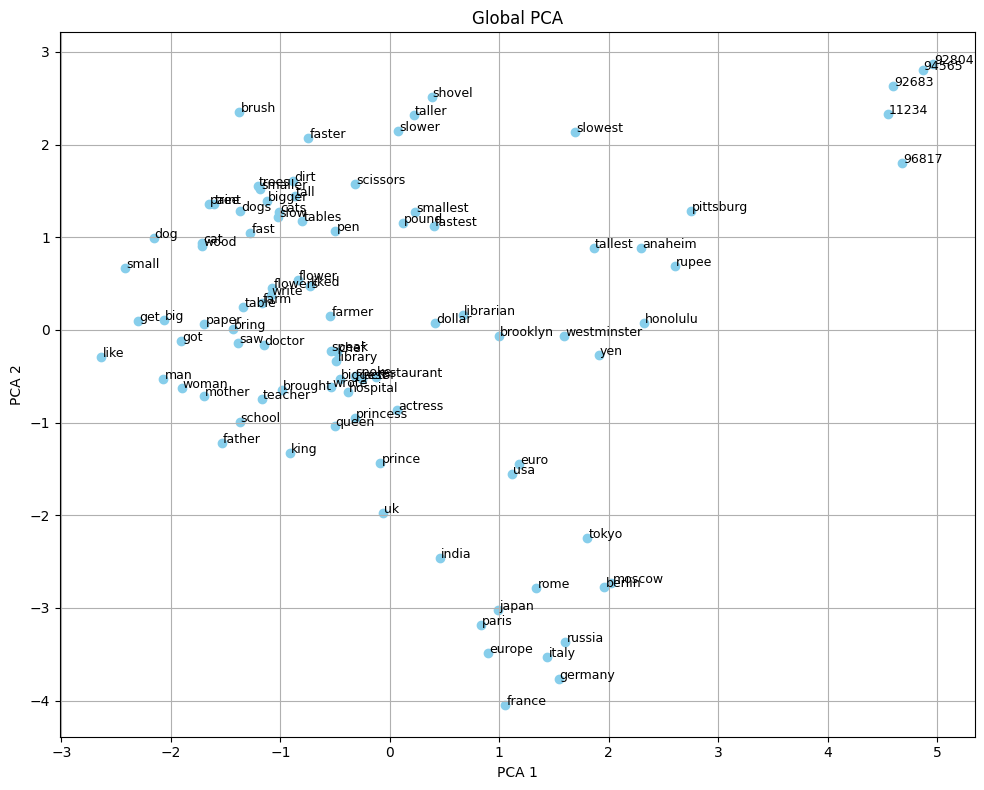

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

used_words = set(word for pairs in filtered_classes.values() for pair in pairs for word in pair)
used_words = sorted(used_words)
X = np.array([glove_vectors[word] for word in used_words])


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], color='skyblue')
for i, word in enumerate(used_words):
    plt.text(X_pca[i, 0] + 0.01, X_pca[i, 1], word, fontsize=9)
plt.title("Global PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()


We can see some clusters forming on the plot. Standing out the most are numbers, countries/cities and superlatives.

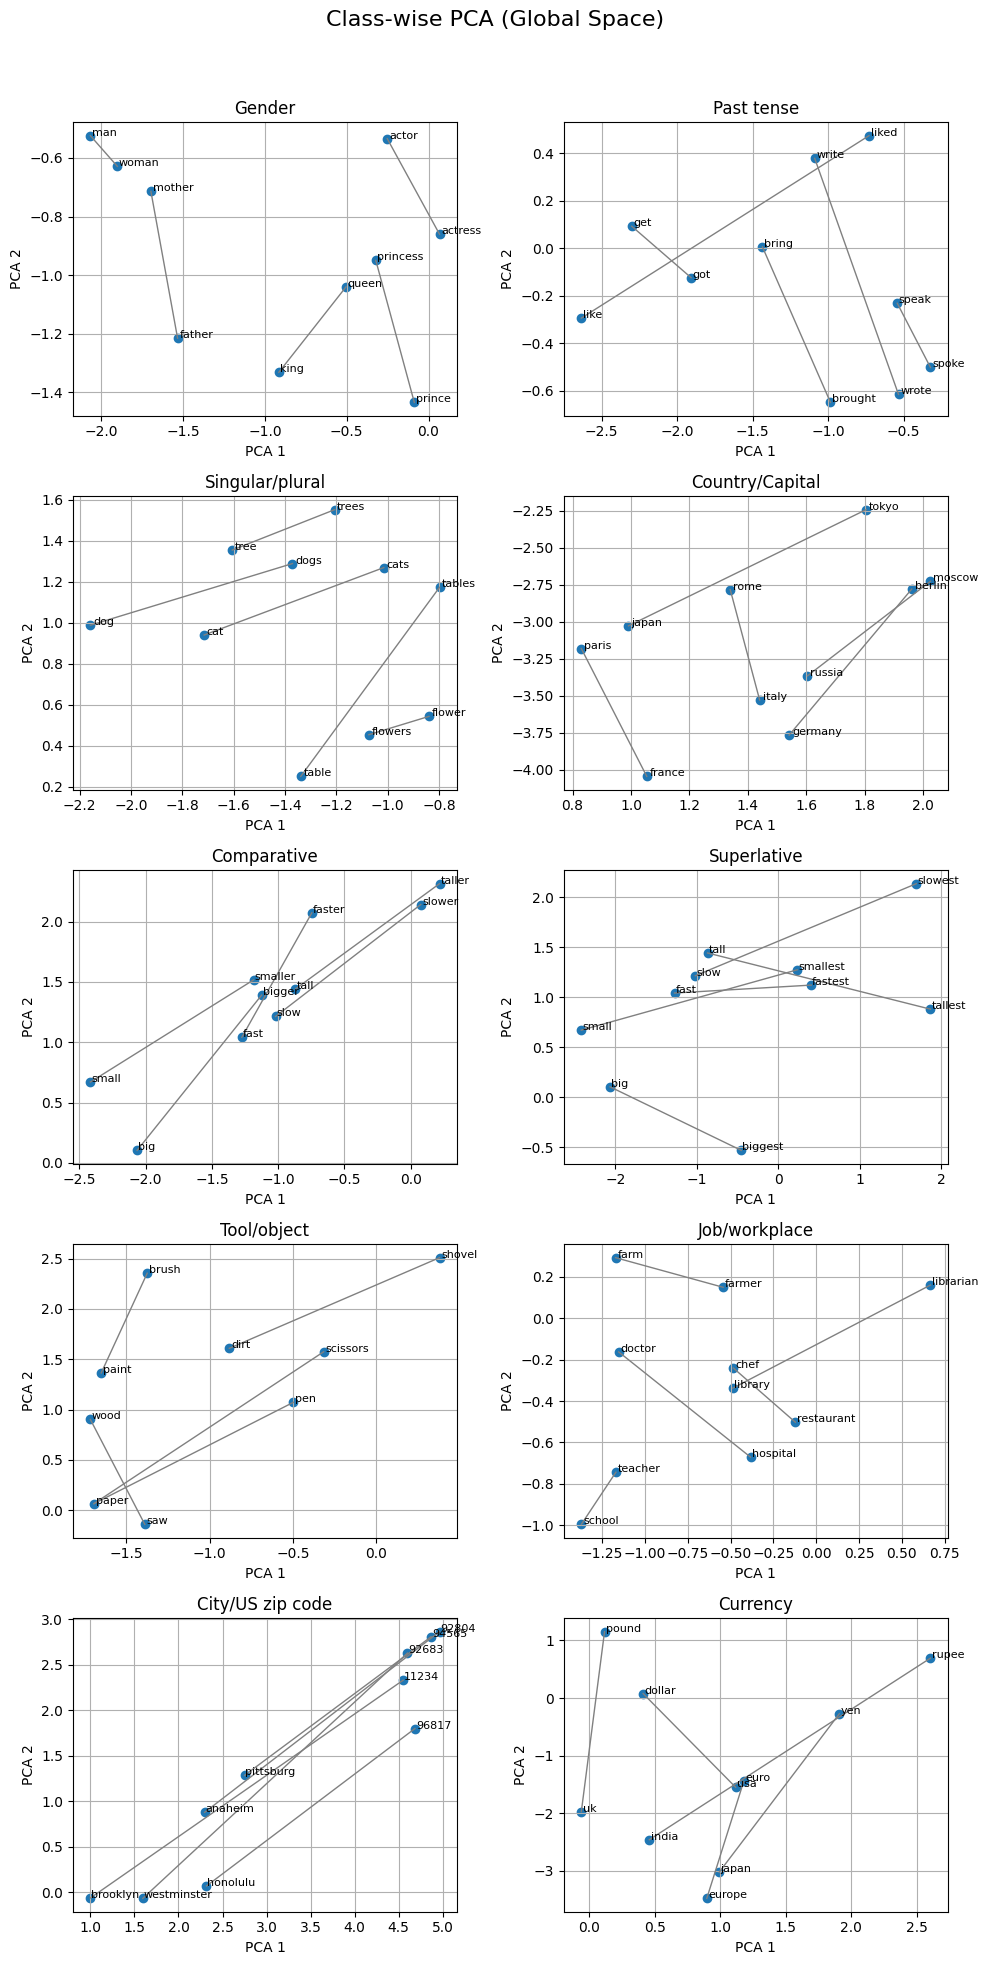

In [6]:
import matplotlib.pyplot as plt

num_classes = len(filtered_classes)
cols = 2
rows = (num_classes + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for idx, (class_name, pairs) in enumerate(filtered_classes.items()):
    ax = axes[idx]
    words = sorted(set(word for a, b in pairs for word in (a, b)))
    coords = {word: X_pca[used_words.index(word)] for word in words}

    ax.scatter(*zip(*coords.values()))
    for word, (x, y) in coords.items():
        ax.text(x + 0.01, y, word, fontsize=8)
    for a, b in pairs:
        if a in coords and b in coords:
            ax.plot(
                [coords[a][0], coords[b][0]],
                [coords[a][1], coords[b][1]],
                color='gray', linestyle='-', linewidth=1
            )

    ax.set_title(class_name)
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    ax.grid(True)

fig.suptitle("Class-wise PCA (Global Space)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Looking at the plots we can see that pairs align along similar directions. This may suggest that word arithmetics we will perform in part 4 will work, i.e. dogs-dog≈cats-cat.

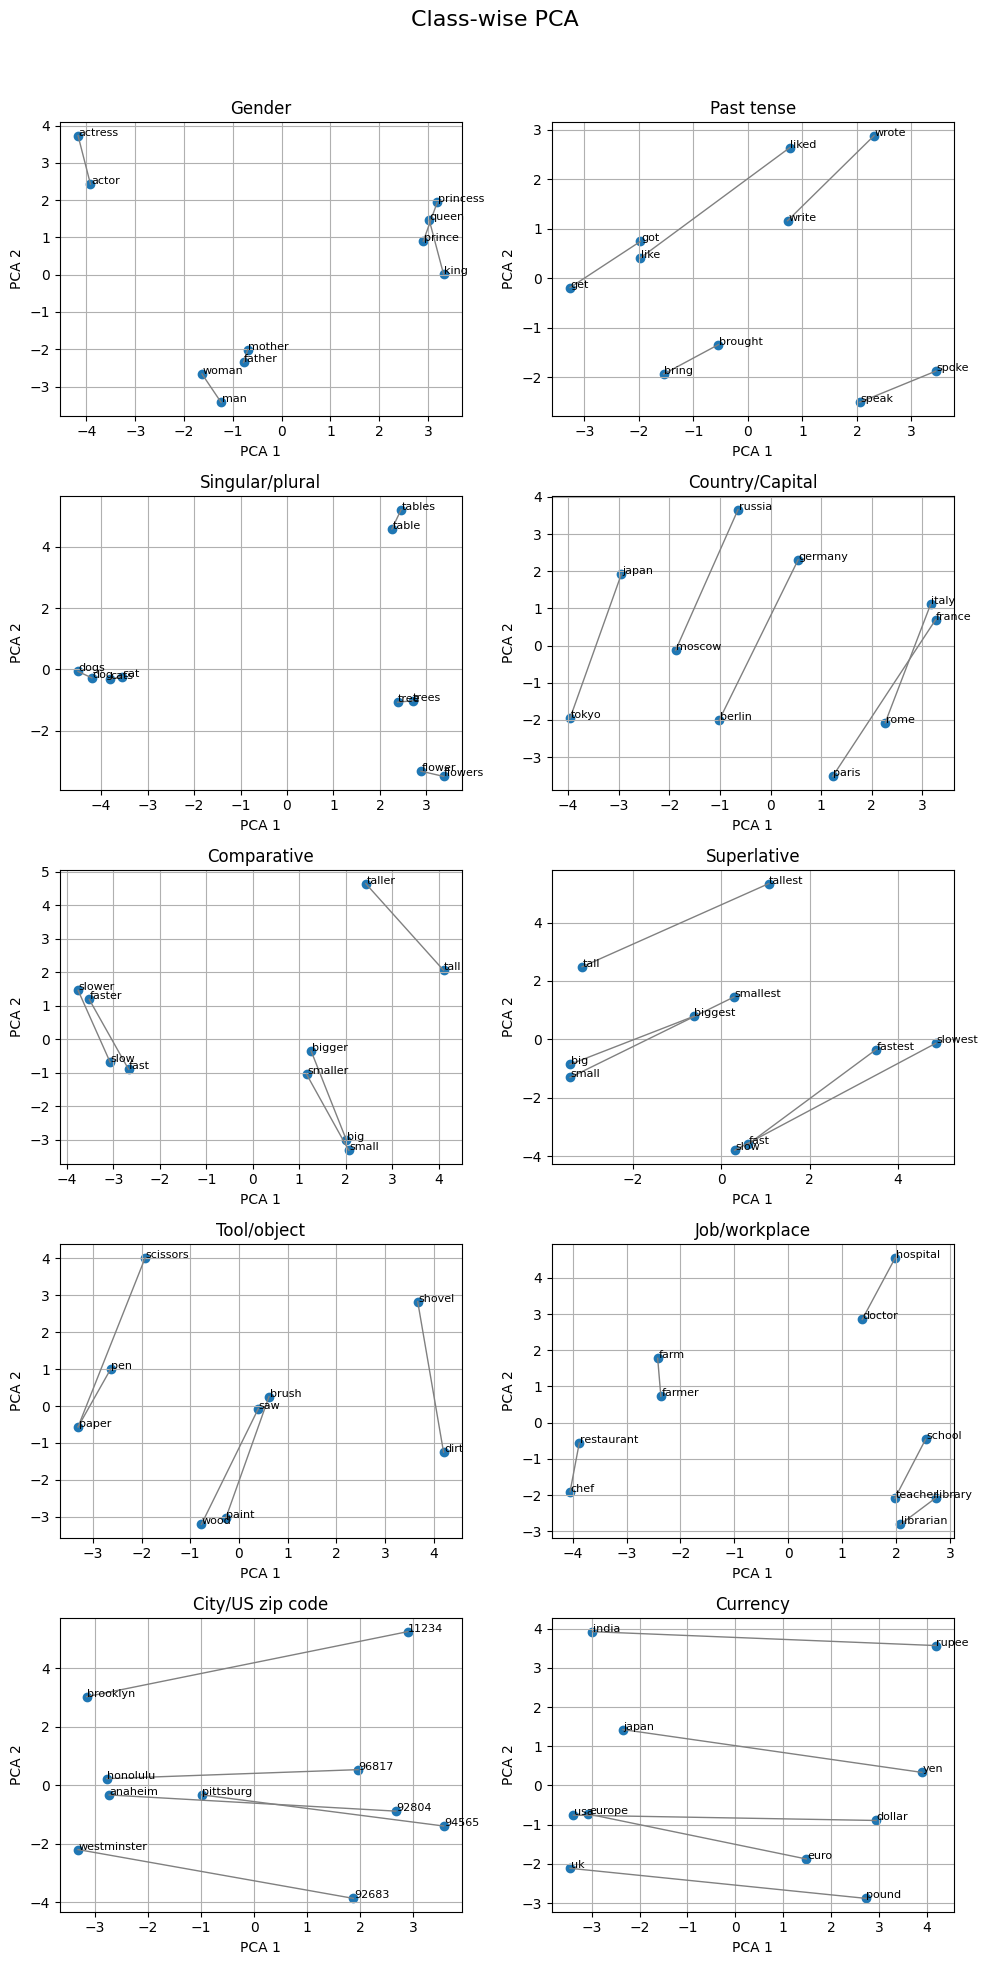

In [7]:
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for idx, (class_name, pairs) in enumerate(filtered_classes.items()):
    ax = axes[idx]
    words = sorted(set(word for a, b in pairs for word in (a, b)))
    local_X = np.array([glove_vectors[w] for w in words])
    local_coords = PCA(n_components=2).fit_transform(local_X)

    coords = {word: local_coords[i] for i, word in enumerate(words)}
    ax.scatter(*zip(*coords.values()))
    for word, (x, y) in coords.items():
        ax.text(x + 0.01, y, word, fontsize=8)

    for a, b in pairs:
        if a in coords and b in coords:
            ax.plot(
                [coords[a][0], coords[b][0]],
                [coords[a][1], coords[b][1]],
                color='gray', linestyle='-', linewidth=1)

    ax.set_title(class_name)
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    ax.grid(True)

fig.suptitle("Class-wise PCA", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


For embedding arithmetic let's use L1 distance, I found that using cosine similarity takes too long.

In [8]:
def find_nearest_L1(vec, glove_vectors, exclude, top_k=5):
    distances = {}
    for word, emb in glove_vectors.items():
        if word in exclude:
            continue
        dist = np.sum(np.abs(vec - emb))
        distances[word] = dist
    return sorted(distances.items(), key=lambda x: x[1])[:top_k]

for class_name, pairs in filtered_classes.items():
    example = pairs[0]
    a, b = example
    candidates = [w for pair in pairs for w in pair if w not in (a, b)]
    if not candidates:
        continue
    c = candidates[0]

    vec_result = glove_vectors[b] - glove_vectors[a] + glove_vectors[c]
    nearest = find_nearest_L1(vec_result, glove_vectors, exclude={a, b, c})

    print(f"\nClass: {class_name}")
    print(f"{b} - {a} + {c} ≈ ?")
    for word, dist in nearest:
        print(f"    {word} (L1 distance: {dist:.4f})")



Class: Gender
queen - king + man ≈ ?
    woman (L1 distance: 68.5999)
    lady (L1 distance: 85.0173)
    girl (L1 distance: 85.7042)
    the_amazing_spider (L1 distance: 91.2799)
    conferencepotawatomi (L1 distance: 91.3935)

Class: Past tense
brought - bring + get ≈ ?
    got (L1 distance: 47.4761)
    getting (L1 distance: 56.2894)
    gotten (L1 distance: 60.3124)
    once (L1 distance: 67.6129)
    already (L1 distance: 68.9971)

Class: Singular/plural
cats - cat + dog ≈ ?
    dogs (L1 distance: 45.3749)
    pets (L1 distance: 80.7470)
    puppies (L1 distance: 81.2104)
    puppy (L1 distance: 82.3615)
    canines (L1 distance: 86.8607)

Class: Country/Capital
paris - france + germany ≈ ?
    berlin (L1 distance: 72.5792)
    munich (L1 distance: 81.5666)
    frankfurt (L1 distance: 81.7236)
    hamburg (L1 distance: 83.8324)
    stuttgart (L1 distance: 88.4041)

Class: Comparative
bigger - big + small ≈ ?
    smaller (L1 distance: 61.4560)
    larger (L1 distance: 67.0832)
   

Classes Gender, Past tense, Singular/plural, Country/Capital, Comparative and Superlative performed as expected. Other classes performed a lot worse.